In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm, linear_model, metrics
import numpy as np
import string
import random
import string
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        try:
            yield eval(l)
        except:
            continue

In [4]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [5]:
dataset = []
for d in readGz("renttherunway_final_data.json.gz"):
    dataset.append(d)


In [6]:
len(dataset)

192462

In [7]:
def heightConversion(h):
    ft, inch = h.split('\' ')
    ft = int(ft)
    inch = int(inch.replace('\"', ''))
    return ft * 12 + inch

In [8]:
new_dataset = []
punctuation = set(string.punctuation)

for d in dataset:
    feature_needed = ['weight', 'height', 'fit', 'size', 'body type', 'review_text', 'review_summary', 'rating']
    keys = list(d.keys())
    if all([i in keys for i in feature_needed]):
        d['weight'] = int(d['weight'].replace("lbs", ""))
        d['height'] = heightConversion(d['height'])
        new_dataset.append(d)

In [9]:
len(new_dataset)

153441

In [10]:
y1 = [d['fit'] for d in new_dataset]

In [12]:
y1 = [d['fit'] for d in new_dataset]
pd.Series(y1).value_counts(normalize=True)

fit      0.736035
small    0.134019
large    0.129946
dtype: float64

In [13]:
dataTrain1, data_vt1, ytrain1, y_vt1 = train_test_split(new_dataset, y1, test_size=0.3, random_state=42)
dataValid1, dataTest1, yvalid1, ytest1 = train_test_split(data_vt1, y_vt1, test_size=0.5, random_state=42)
len(dataTrain1), len(dataValid1), len(dataTest1)

(107408, 23016, 23017)

In [14]:
Xtrain1 = [[1, d['weight'], d['height'], d['size']] for d in dataTrain1]
Xvalid1 = [[1, d['weight'], d['height'], d['size']] for d in dataValid1]
Xtest1 = [[1, d['weight'], d['height'], d['size']] for d in dataTest1]

In [16]:
# Baseline Model - using only weight, height and size
mods = {}
F1Valid = {}
F1Train = {}
F1scores = []
bestMod = None
bestVal = None
bestI = None
for i in range(2,25):
    baselineMod = DecisionTreeClassifier(max_depth=i)
    baselineMod.fit(Xtrain1,ytrain1)
    mods[i] = baselineMod
    blPred = baselineMod.predict(Xvalid1)
    blF1 = metrics.f1_score(yvalid1, blPred, average='weighted',zero_division=0)
    F1Valid[i] = blF1
    blPredTr = baselineMod.predict(Xtrain1)
    blF1Tr = metrics.f1_score(ytrain1, blPredTr, average='weighted',zero_division=0)
    F1Train[i] = blF1Tr
    F1scores.append(blF1)
    print("Max_depth = {}, F_1 score is {}.".format(str(i), str(blF1)))
    if bestVal == None or blF1 > bestVal:
        bestVal = blF1
        bestMod = baselineMod
        bestI = i

Max_depth = 2, F_1 score is 0.6211854113684363.
Max_depth = 3, F_1 score is 0.6211854113684363.
Max_depth = 4, F_1 score is 0.6211854113684363.
Max_depth = 5, F_1 score is 0.6211854113684363.
Max_depth = 6, F_1 score is 0.6211797652217251.
Max_depth = 7, F_1 score is 0.6212300680822704.
Max_depth = 8, F_1 score is 0.6235943992050079.
Max_depth = 9, F_1 score is 0.6225766046133574.
Max_depth = 10, F_1 score is 0.6237080607084854.
Max_depth = 11, F_1 score is 0.6244063132109235.
Max_depth = 12, F_1 score is 0.6248373358521497.
Max_depth = 13, F_1 score is 0.6254390746124412.
Max_depth = 14, F_1 score is 0.6252848153909614.
Max_depth = 15, F_1 score is 0.6262328467310826.
Max_depth = 16, F_1 score is 0.6272025440971651.
Max_depth = 17, F_1 score is 0.6274801751591385.
Max_depth = 18, F_1 score is 0.6280711544603741.
Max_depth = 19, F_1 score is 0.6277945877601003.
Max_depth = 20, F_1 score is 0.6279067207496496.
Max_depth = 21, F_1 score is 0.6279426564939684.
Max_depth = 22, F_1 score is

In [17]:
bestI, bestVal

(18, 0.6280711544603741)

In [18]:
predTest = bestMod.predict(Xtest1)
f1Test1 = metrics.f1_score(ytest1, predTest, average='weighted',zero_division=0)
f1Test1

0.6369932517379904

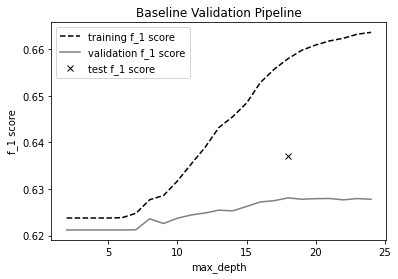

In [19]:
plt.xticks([])
plt.xlabel(r"max_depth")
plt.ylabel(r"f_1 score")
plt.title(r"Baseline Validation Pipeline")
plt.xscale('linear')
plt.plot(range(2,25), list(F1Train.values()), color='k', linestyle='--', label='training f_1 score')
plt.plot(range(2,25), list(F1Valid.values()), color='grey',zorder=4,label="validation f_1 score")
plt.plot([bestI], [f1Test1], linestyle='', marker='x', color='k', label="test f_1 score")
plt.legend(loc='best')
plt.show()

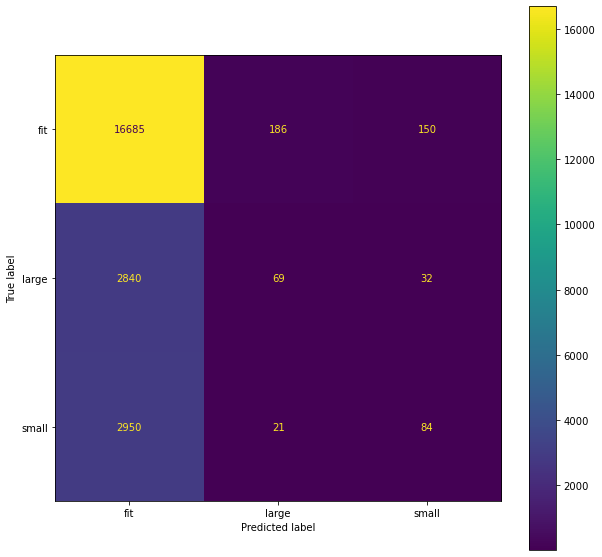

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(bestMod, Xtest1, ytest1, ax=ax)
plt.show()

In [94]:
wordCount2 = defaultdict(int)
punctuation2 = set(string.punctuation)
stemmer2 = PorterStemmer()
sw2 = stopwords.words("English")
for d in dataTrain1:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation2])
    s = ''.join([c for c in d['review_summary'].lower() if not c in punctuation2])
    for w in r.split() + s.split():
        w = stemmer2.stem(w)
        wordCount2[w] += 1

len(wordCount2)

31232

In [95]:
counts2 = [(wordCount2[w],w) for w in wordCount2 if w not in sw2]
counts2.sort()
counts2.reverse()
len(counts2)

31117

In [65]:
words2 = [x[1] for x in counts2[:4000]]

In [66]:
wordId2 = dict(zip(words2, range(len(words2))))
wordSet2 = set(words2)

In [71]:
def feature3(d): 
    feat = [0]*len(words2)
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation2])
    s = ''.join([c for c in d['review_summary'].lower() if not c in punctuation2])
    for w in r.split() + s.split():
        w = stemmer2.stem(w)
        if w in words2:
            feat[wordId2[w]] += 1
    return [1] + [d['weight'], d['height'], d['size']] + feat

In [72]:
Xtrain3 = [feature3(d) for d in dataTrain1]

In [73]:
Xvalid3 = [feature3(d) for d in dataValid1]

In [74]:
Xtest3 = [feature3(d) for d in dataTest1]

In [112]:
# Track the model which works best on the validation set
bestModel = None
bestValue = None
bestC = None
models = dict()
f1Valid = dict()
f1Train = dict()

for c in range(2,25):
    model = DecisionTreeClassifier(max_depth=c)
    model.fit(Xtrain3, ytrain1)
    models[c] = model
    predictValid = model.predict(Xvalid3)
    f1V = metrics.f1_score(yvalid1, predictValid, average='weighted', zero_division=0)
    f1Valid[c] = f1V
    predictTrain = model.predict(Xtrain3)
    f1T = metrics.f1_score(ytrain1, predictTrain, average='weighted', zero_division=0)
    f1Train[c] = f1T
    print("Max_depth = " + str(c) + ", validation F_1 score = " + str(f1V))
    if bestValue == None or f1V > bestValue:
        bestValue = f1V
        bestModel = model
        bestC = c

Max_depth = 2, validation F_1 score = 0.711063843720865
Max_depth = 3, validation F_1 score = 0.7307740995792468
Max_depth = 4, validation F_1 score = 0.7208910737256707
Max_depth = 5, validation F_1 score = 0.7382379875172989
Max_depth = 6, validation F_1 score = 0.7591255255513193
Max_depth = 7, validation F_1 score = 0.7582206042451941
Max_depth = 8, validation F_1 score = 0.7575262790847063
Max_depth = 9, validation F_1 score = 0.7570216721771734
Max_depth = 10, validation F_1 score = 0.7611609645359514
Max_depth = 11, validation F_1 score = 0.7637408108238847
Max_depth = 12, validation F_1 score = 0.7644663303710587
Max_depth = 13, validation F_1 score = 0.7660669817506426
Max_depth = 14, validation F_1 score = 0.7646109229364622
Max_depth = 15, validation F_1 score = 0.7639681365517051
Max_depth = 16, validation F_1 score = 0.7624684820956116
Max_depth = 17, validation F_1 score = 0.7624728122275578
Max_depth = 18, validation F_1 score = 0.7609507610104935
Max_depth = 19, validat

In [113]:
bestC, bestValue

(13, 0.7660669817506426)

In [114]:
predictTest = bestModel.predict(Xtest3)
f1Test = metrics.f1_score(ytest1, predictTest, average='weighted',zero_division=0)
f1Test

0.7707001748260572

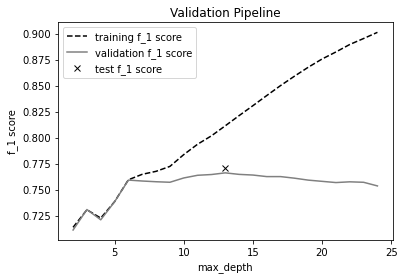

In [115]:
plt.xticks([])
plt.xlabel(r"max_depth")
plt.ylabel(r"f_1 score")
plt.title(r"Validation Pipeline")
plt.xscale('linear')
plt.plot(range(2,25), list(f1Train.values()), color='k', linestyle='--', label='training f_1 score')
plt.plot(range(2,25), list(f1Valid.values()), color='grey',zorder=4,label="validation f_1 score")
plt.plot([bestC], [f1Test], linestyle='', marker='x', color='k', label="test f_1 score")
plt.legend(loc='best')
plt.show()

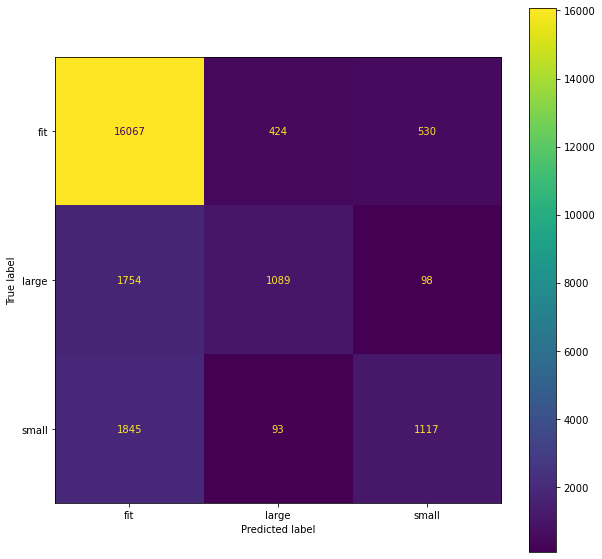

In [116]:
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(bestModel, Xtest3, ytest1, ax=ax)
plt.show()